In [2]:
import os
import sys
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt
from Naive_DAE import Naive_DAE,Dropout_DAE
import AE_Stats
from load_data_fn import load_data,load_data_no_filter

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import importlib
from telescope_torch import *
import time
from losses import new_loss,AE_MSE, combo_loss

In [54]:
os.listdir('models/batched_models'
)

['test',
 'batch_4_models_tt_bar_norm_mean_0_var_1',
 'batch_4_models_MIP_norm_mean_0_var_1',
 'batch_4_models_tt_bar_norm_mean_0_var_1_sim_energy',
 '2023-03-29_21-07-24',
 'wafer_layer_split_mip_std_1_mean_nonzero',
 'wafer_layer_split_mip_std_non_one_mean_nonzero',
 'wafer_layer_split_mip_std_1_mean_nonzero_dt_size_100000',
 'wafer_layer_split_mip_std_1_mean_nonzero_dt_size_100000_non_trained_initial',
 'wafer_layer_split_mip_std_1_mean_nonzero_dt_size_10000',
 'saved_trained_models',
 'wafer_layer_split_mip_std_1_mean_nonzero_bad_layers',
 'wafer_layer_split_mip_std_1_mean_nonzero_all_old_model',
 'wafer_layer_split_mip_std_1_mean_nonzero_450_250_100',
 'wafer_layer_split_mip_std_1_mean_nonzero_telescope',
 'wafer_layer_split_mip_std_1_mean_nonzero_telescope_2',
 'wafer_layer_split_mip_std_1_mean_nonzero_greater_7',
 'cond_AE_wafer_layer_split_mip_std_1_mean_nonzero',
 'cond_AE_wafer_layer_split_mip_std_1_mean_nonzero_greater_7_initial',
 'cond_AE_wafer_layer_split_mip_std_1_mean_n

In [8]:
model_path = 'models/batched_models/conda_450_150_combo_loss'
data_path ='MIT_TTbar'

In [13]:
models = os.listdir(model_path)

In [14]:
performance = []
all_data =[]
all_pred =[]
for m in models:
    sub = os.listdir(os.path.join(model_path,m))
    loaded_models = []
    for sm in sub:
#         loaded_models.append([sm, torch.load(os.path.join(model_path,m,sm))])
        model = torch.load(os.path.join(model_path,m,sm)).to('cpu')
        data = torch.load(os.path.join(data_path,sm))
        pred = model(data.to('cpu')[:,0:48])
        performance.append([sm, data, pred])
        if int(0.05*len(data))< 2000:
            dt_size = int(0.05*len(data))
        else:
            dt_size = 2000
        all_data.append(torch.tensor(data[-dt_size:]))
        all_pred.append(torch.tensor(pred[-dt_size:]))
    # now all our models are loaded in
    # need to get data to evaluate them
    
all_data_tensor = torch.vstack(all_data)
all_pred_tensor = torch.vstack(all_pred)    

/tmp/ipykernel_214702/365943737.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_data.append(torch.tensor(data[-dt_size:]))
/tmp/ipykernel_214702/365943737.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_pred.append(torch.tensor(pred[-dt_size:]))


In [15]:
len(all_data_tensor)

210046

MSE 7.00657844543457
Median 1.1539981365203857
Standard Devitaion 35.567726135253906
Average std error 6.265767574310303
Average % Error of Energy Reconstruction nan


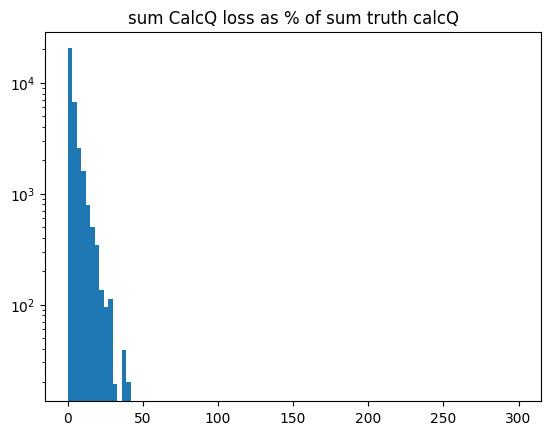

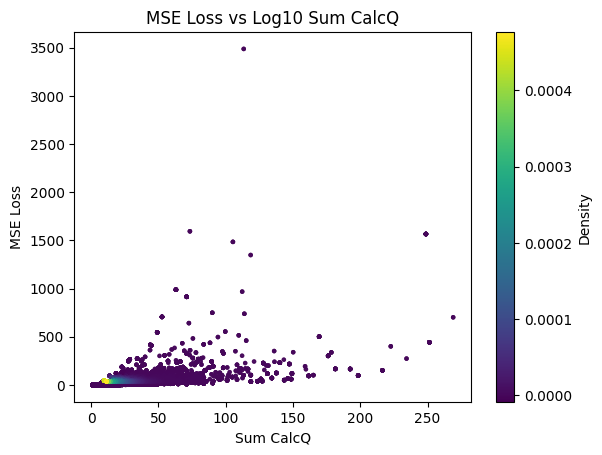

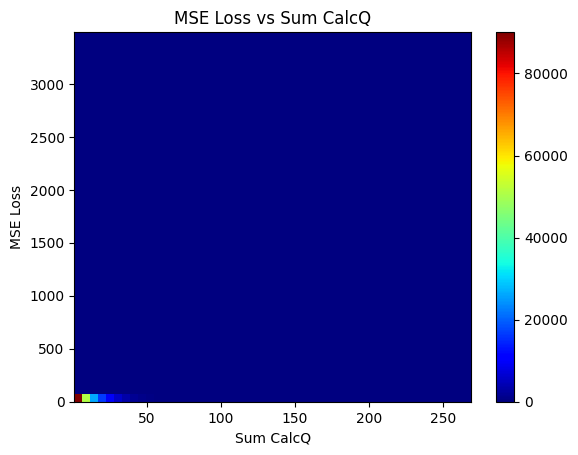

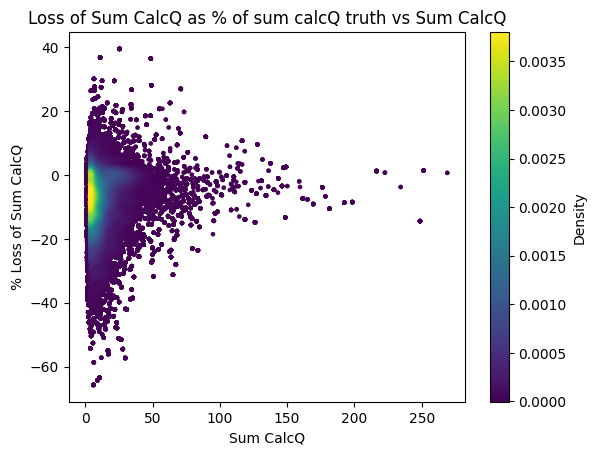

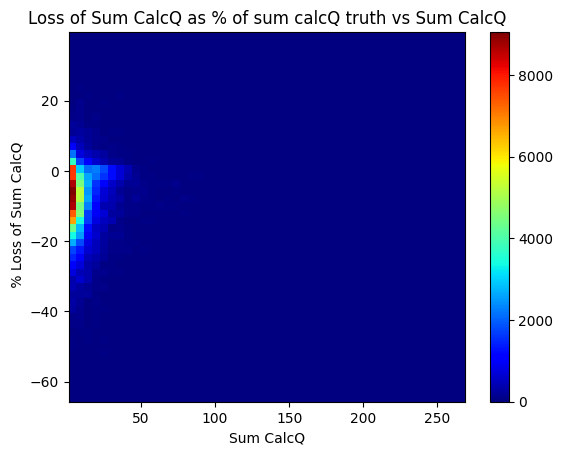

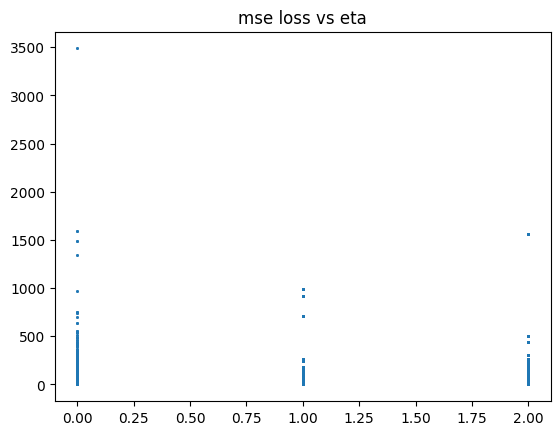

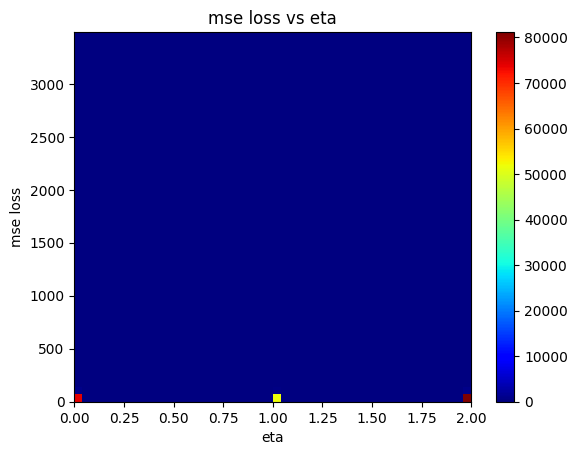

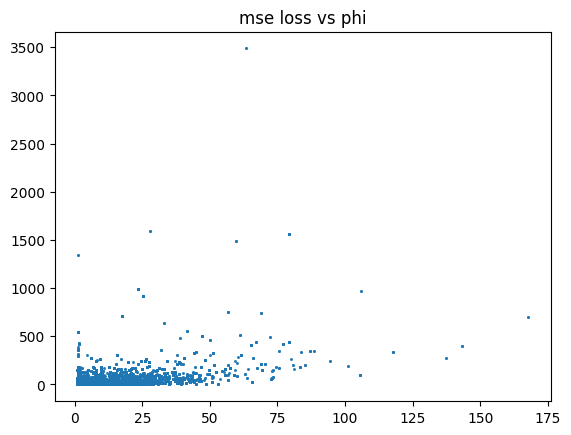

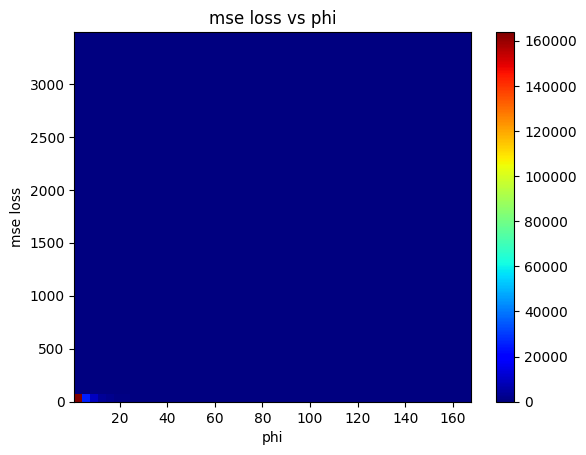

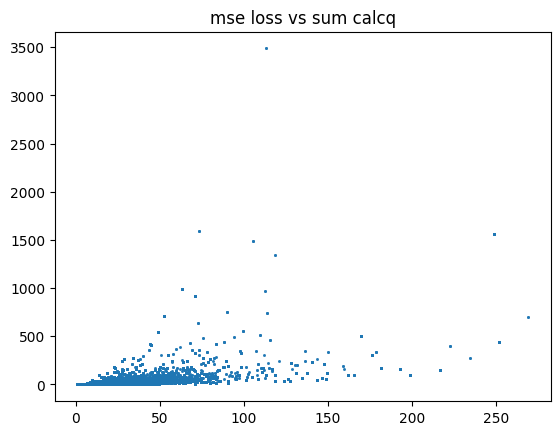

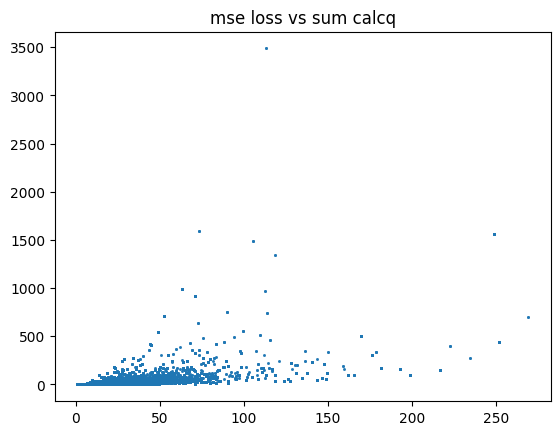

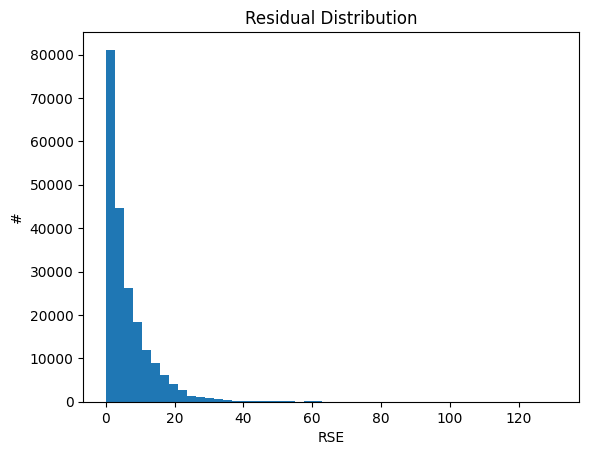

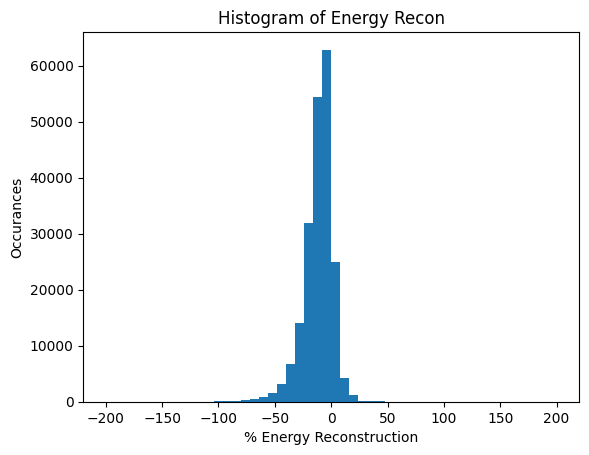

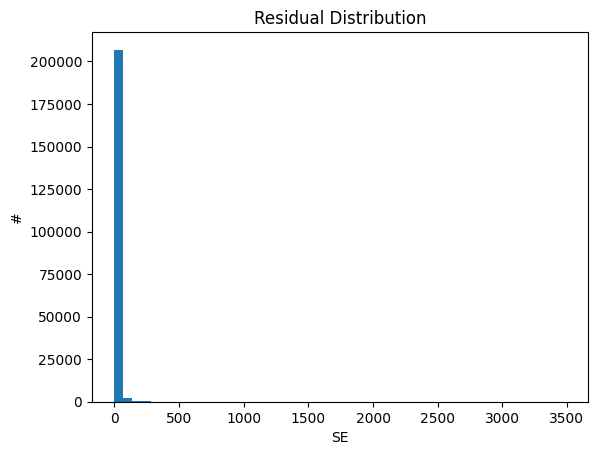

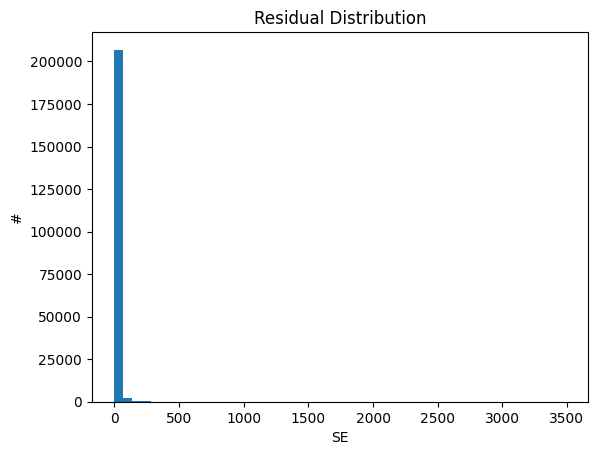

tensor([[ 1.0000,  2.5223, 16.0988,  1.3963,  5.6198],
        [ 1.0000,  3.2363, 16.0826,  4.9600,  8.4445],
        [ 1.0000,  1.4194, 10.6044,  3.8874,  8.1744],
        ...,
        [ 2.0000,  6.7314,  4.0367,  0.2682,  0.8022],
        [ 2.0000,  6.5904,  2.7135,  0.0851,  0.5265],
        [ 2.0000,  8.6400,  3.7482,  0.3185,  1.2156]])

In [16]:
AE_Stats.generate_stats(all_pred_tensor, all_data_tensor[:,0:48],all_data_tensor)

In [43]:
all_pred_tensor[0]

tensor([0.0000, 0.0000, 0.0000, 0.2464, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1619, 0.0000, 0.0000, 0.2077, 0.0000, 0.0000, 0.0000, 0.2546, 2.3348,
        0.1404, 0.0000, 1.9547, 0.0000, 0.1960, 0.0000, 0.0000, 0.0000, 0.0000,
        0.4077, 0.0000, 0.3839, 0.0000, 0.0000, 0.1673, 0.0000, 0.2663, 0.0964,
        0.6881, 2.3299, 3.2260, 0.0000, 0.2004, 0.0000, 0.4612, 0.0000, 0.3263,
        0.0000, 0.0984, 0.0000])

In [45]:
all_data_tensor[0,0:48]

tensor([0.2844, 0.1419, 0.0000, 0.0472, 0.0308, 0.0000, 0.0461, 0.0000, 0.0000,
        0.1649, 0.0000, 0.3597, 0.0146, 0.3213, 0.0000, 0.0000, 0.0000, 2.4274,
        0.0000, 0.0000, 2.0669, 0.2023, 0.0000, 0.1290, 0.0000, 0.2024, 0.0000,
        0.2906, 0.0517, 0.3378, 0.0661, 0.0000, 0.0000, 0.3667, 0.1721, 0.0000,
        0.6123, 2.5068, 3.3345, 0.0492, 0.1413, 0.1766, 0.3611, 0.0000, 0.1931,
        0.0000, 0.0000, 0.0000])

In [5]:
def retrain_models(data,mse,mse_threshold = 5, batch = 100,override = True, model_params = [],max_dt_size = 40000,epochs = 100,lr = 0.001, dir_label = time.strftime("%Y-%m-%d_%H-%M-%S", time.gmtime()), path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models'):
    path = os.path.join(path, dir_label)
    
    if not (os.path.exists(path) and os.path.isdir(path)):
        os.mkdir(path)
    
    trained_models = os.listdir(path)
    mse_to_retrain = []
    device = 'cuda'
    train_info = []
    i = 0
    for d in data:
        dt = d[0]
        cur_mse = mse[i]
        i = i + 1
        params = []
        if cur_mse > mse_threshold:
            mse_to_retrain.append(cur_mse)
            print(f'Model {d[1]} has MSE of {cur_mse} and is being retrained')
            if params == 'retrain':
                params.append(torch.load(os.path.join(path,d[1])))
            elif params == []:
                if int(d[1][8]) == 1:
                    mt = torch.load('models/dt_1_greater_0_450_250_100_dif_2')
                    mt.decoders.add_module('ReLU',nn.ReLU())
                    params.append(mt)
                elif int(d[1][8]) == 2:
                    mt = torch.load('models/dt_2_greater_0_450_250_100_dif_2')
                    mt.decoders.add_module('ReLU',nn.ReLU())
                    params.append(mt)
                else:
                    mt = torch.load('models/dt_3_greater_0_450_250_100_dif_2')
                    mt.decoders.add_module('ReLU',nn.ReLU())
                    params.append(mt)
            else:
                print(f'created model {d[1]} with {model_params}')
                params.append(Naive_DAE(model_params))
               

            params.append(dt)

            #Limiting size of training/testing to limit runtime
            if len(dt) <= max_dt_size:
                params.append(int(0.8*len(dt)))
                params.append(int(0.19*len(dt)))
            else:
                params.append(int(0.8*max_dt_size))
                params.append(int(0.19*max_dt_size))

            params.append(d[1])
            params.append(dir_label)
            train_info.append(params)
            
    i = 0
    for params in train_info:
        cur_mse = mse_to_retrain[i]
        print(f'TRAINING MODEL {params[4]}')
        i=i+1
        #Training mode
        retrain_model(params[0].to(device),
                      cur_mse,
                      params[1].to(device),
                      params[2],
                      params[3],
                      params[4],
                      params[5],
                      path,batch = batch,
                      num_epochs = epochs,
                      lr = lr)
        #clear cuda after training each model
        torch.cuda.empty_cache()




In [6]:
def retrain_models_specified(data,
                             mse,
                             specified,
                             loss = new_loss,
                             batch = 100,
                             override = True,
                             model_params = [],
                             append_ReLU = False,
                             max_dt_size = 40000,
                             epochs = 100,
                             path_1 = 'models/MIP_dt_1_450_250_greater_1',
                             path_2 = 'models/MIP_dt_1_450_250_greater_2',
                             path_3 = 'models/MIP_dt_1_450_250_greater_3',
                             lr = 0.001,
                             dir_label = time.strftime("%Y-%m-%d_%H-%M-%S", time.gmtime()),
                             path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models'):
    path = os.path.join(path, dir_label)
    
    if not (os.path.exists(path) and os.path.isdir(path)):
        os.mkdir(path)
    
    
    mse_to_retrain = []
    device = 'cuda'
    train_info = []
    i = 0
    for d in data:
        dt = d[0]
        cur_mse = mse[i]
        i = i + 1
        params = []
        if d[1] in specified:
            mse_to_retrain.append(cur_mse)
            print(f'Model {d[1]} is being retrained')
            if model_params == 'retrain':
                params.append(torch.load(os.path.join(path,d[1])))
            elif model_params == []:
                if int(d[1][8]) == 1:
                    mt = torch.load(path_1)
                    if append_ReLU:
                        mt.decoders.add_module('ReLU',nn.ReLU())
                    params.append(mt)
                    
                elif int(d[1][8]) == 2:
                    mt = torch.load(path_2)
                    if append_ReLU:
                        mt.decoders.add_module('ReLU',nn.ReLU())
                    params.append(mt)
                else:
                    mt = torch.load(path_3)
                    if append_ReLU:
                        mt.decoders.add_module('ReLU',nn.ReLU())
                    params.append(mt)
            else:
                print(f'created model {d[1]} with {model_params}')
                params.append(Naive_DAE(model_params))
               

            params.append(dt)

            #Limiting size of training/testing to limit runtime
            if len(dt) <= max_dt_size:
                params.append(int(0.8*len(dt)))
                params.append(int(0.19*len(dt)))
            else:
                params.append(int(0.8*max_dt_size))
                params.append(int(0.19*max_dt_size))

            params.append(d[1])
            params.append(dir_label)
            
            train_info.append(params)
            
    i = 0
    for params in train_info:
        cur_mse = mse_to_retrain[i]
        print(f'TRAINING MODEL {params[4]}')
        i=i+1
        #Training mode
        retrain_model(params[0].to(device),
                      cur_mse,
                      params[1].to(device),
                      params[2],
                      params[3],
                      params[4],
                      params[5],
                      path,batch = batch,
                      num_epochs = epochs,
                      loss = loss,
                      lr = lr)
        #clear cuda after training each model
        torch.cuda.empty_cache()

In [7]:
def retrain_model(model, mse,dt, size_train, size_test,label,cur_directory,path, loss = new_loss, num_epochs = 200, lr = 0.001,batch = 100):
    print(f'TRAINING INFO:')
    print(f'Total Dataset Size: {size_train + size_test}')
    mean = 0
    std = 1
    train_loc = dt[0:size_train]
    test_loc = dt[-size_test:]
    # train = torch.vstack([train,largest[0:1000]] )
    train_loc=train_loc[torch.randperm(train_loc.size()[0])]
    test_loc=test_loc[torch.randperm(test_loc.size()[0])]
    train_loc_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(train_loc)),
        batch_size=batch,
        shuffle=False
    )

    test_loc_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(test_loc)),
        batch_size=batch,
        shuffle=False
    )

    train = dt[0:size_train,0:48]
    test = dt[-size_test:,0:48]
    # train = torch.vstack([train,largest[0:1000]] )
    train=train[torch.randperm(train.size()[0])]
    test=test[torch.randperm(test.size()[0])]
    train_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(train)),
        batch_size=batch,
        shuffle=False
    )

    test_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(test)),
        batch_size=batch,
        shuffle=False
    )
    #fine-tune autoencoder
    #batch 500
    
    optimizer = optim.Adam(model.parameters(), lr,weight_decay=5e-2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)
    
    all_test_losses = []
    all_train_losses = []
    # train
    running_loss = float("inf")
    for epoch in range(num_epochs):
        
        losses = []

        for i, data_list in enumerate(train_d1_flat):
            
            model.train()
            data = data_list[0]
            v_pred = model(data)

            
            batch_loss = torch.mean(telescopeMSE2(data[:,0:48], v_pred))
            all_train_losses.append(batch_loss.item())
            losses.append(batch_loss.item())
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
            
        scheduler.step(batch_loss)
        
        data_test = test
        model.eval()
        test_pred = model(data_test)
        batch_test = torch.mean(telescopeMSE2(data_test[:,0:48], test_pred))
        all_test_losses.append(batch_test.item())
        running_loss = np.mean(losses)
        runningtest_loss = batch_test.item()
        if epoch % 25 == 0:
            print('Epoch {}, lr {}'.format(
                epoch, optimizer.param_groups[0]['lr']))
            print(f"Epoch {epoch}: Train {AE_MSE(v_pred, data):.3f}, Test {AE_MSE(test_pred, data_test):.3f}")
            print(f"MSE NON-NORMALIZED: Train MSE {running_loss*3.5280**2:.3f}, Test MSE {runningtest_loss*3.5280**2:.3f}")

    model.eval()
#     AE_Stats.gen_all_stats(model(dt[-size_test:,0:48]).cpu(),dt[-size_test:,0:48].cpu(),dt[-size_test:].cpu())
    if AE_MSE(test_pred, data_test)*3.5280**2 < mse:
        torch.save(model,f'{path}/{label}')
    else:
        print(f'MSE of {AE_MSE(test_pred, data_test)*3.5280**2} was larger than initial of {mse} and was not saved')

In [10]:
# provide path to data
data_path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/MIT_TTbar'

In [11]:
all_files = os.listdir(data_path)
dt_files = []
for f in all_files:
    if f[0:7] == 'dt_norm' and (f[-3:] != 'low' and f[-4:] !='high'):
        dt_files.append(f)
      

In [37]:
retrain_condAEs(data_path,
              dt_files,
               model_params = 'retrain',
              override = False,
              loss = combo_loss, 
              path_1 = 'models/combo_loss_all',
              path_2 = 'models/combo_loss_all',
              path_3 = 'models/combo_loss_all',
             dir_label ='condAE_mean_split_450_250_combo_loss',
             epochs= 1,
             tele = False,
             batch = 100, 
             lr = 8.5e-9)

Data Loaded
Performance Calculated
TRAINING MODEL dt_norm_3_36: 1/82
LOW
TRAINING INFO:
Total Dataset Size: 26476
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.135, Test 0.135
MSE NON-NORMALIZED: Train MSE 1.479, Test MSE 1.633
mse was not improved, model not saved
HIGH
TRAINING INFO:
Total Dataset Size: 26476
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.135, Test 0.135
MSE NON-NORMALIZED: Train MSE 1.481, Test MSE 1.637
mse was not improved, model not saved
TRAINING MODEL dt_norm_3_30: 2/82
LOW
TRAINING INFO:
Total Dataset Size: 61386
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.226, Test 0.225
MSE NON-NORMALIZED: Train MSE 2.231, Test MSE 2.667
mse was not improved, model not saved
HIGH
TRAINING INFO:
Total Dataset Size: 61386
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.227, Test 0.226
MSE NON-NORMALIZED: Train MSE 2.428, Test MSE 2.676
mse was not improved, model not saved
TRAINING MODEL dt_norm_3_31: 3/82
LOW
TRAINING INFO:
Total Dataset Size: 65367
Epoch 0, lr 8.5e-09
Epoch 0: Train 0.186, Test 0.186
MSE NON-NOR

KeyboardInterrupt: 

In [3]:
batch = 100,
override = True
model_params = []
loss = new_loss
tele = False
path_1 = 'models/MIP_dt_1_450_250_greater_1'
path_2 = 'models/MIP_dt_1_450_250_greater_1'
path_3 = 'models/MIP_dt_1_450_250_greater_1'
append_ReLU = False
max_dt_size = 40000
epochs = 100
lr = 0.001


In [6]:
path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models'
dir_label ='condAE_mean_split_450_250_combo_loss'
path = os.path.join(path, dir_label)

In [7]:
trained_models = os.listdir(path)
device = 'cuda'
train_info = []

In [14]:
data = []
    
for d in dt_files:
    low = torch.load(os.path.join(data_path,d+'_low'))
    high = torch.load(os.path.join(data_path,d+'_high'))
    data.append(cond_storage(d,low,high, max_dt_size))

In [24]:
performance = []
for d in data:
    low_mse = AE_MSE(d.low_test[:,0:48].to('cpu'),torch.load(os.path.join(path,d.name,d.name+'_low')).to('cpu')(d.low_test[:,0:48].to('cpu')))
    high_mse = AE_MSE(d.high_test[:,0:48].to('cpu'),torch.load(os.path.join(path,d.name,d.name+'_high')).to('cpu')(d.high_test[:,0:48].to('cpu')))
    performance.append([d.name,low_mse.item(),high_mse.item()])

In [36]:
def retrain_condAEs(data_path,
                  dt_files,
                 batch = 100,
                 override = True,
                 model_params = [],
                 loss = new_loss,
                 tele = False,
                 path_1 = 'models/MIP_dt_1_450_250_greater_1',
                 path_2 = 'models/MIP_dt_1_450_250_greater_1',
                 path_3 = 'models/MIP_dt_1_450_250_greater_1',
                 append_ReLU = False,
                 max_dt_size = 40000,
                 mse_threshold = 10,
                 epochs = 100,
                 lr = 0.001,
                 dir_label = time.strftime("%Y-%m-%d_%H-%M-%S",
                                           time.gmtime()),
                 path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models'):
    path = os.path.join(path, dir_label)
    if not (os.path.exists(path) and os.path.isdir(path)):
        os.mkdir(path)
        for f in dt_files:
            os.mkdir(os.path.join(path, f))
    
    trained_models = os.listdir(path)
    device = 'cuda'
    train_info = []
    
    data = []
    
    
    
    for d in dt_files:
        low = torch.load(os.path.join(data_path,d+'_low'))
        high = torch.load(os.path.join(data_path,d+'_high'))
        data.append(cond_storage(d,low,high, max_dt_size))
    print('Data Loaded')
    #Generate Performance for retrain
    performance = []
    for d in data:
        low_mse = AE_MSE(d.low_test[:,0:48].to('cpu'),torch.load(os.path.join(path,d.name,d.name+'_low')).to('cpu')(d.low_test[:,0:48].to('cpu')))
        high_mse = AE_MSE(d.high_test[:,0:48].to('cpu'),torch.load(os.path.join(path,d.name,d.name+'_high')).to('cpu')(d.high_test[:,0:48].to('cpu')))
        performance.append([d.name,low_mse.item(),high_mse.item()])
    print('Performance Calculated')
    for d,p in zip(data,performance):
        params = []
        if model_params == 'retrain':
            params.append('retrain')
        else:
            params.append(Naive_DAE(model_params))

        params.append(d)

        #Limiting size of training/testing to limit runtime

        params.append(dir_label)
        params.append(p)
        train_info.append(params)
        
                
    i = 0
    for params in train_info:
        i = i+1
        print(f'TRAINING MODEL {params[1].name}: {i}/{len(train_info)}')
        #Training model
        print('LOW')
        if params[0] == 'retrain':
            model_low = torch.load(os.path.join(path,d.name, d.name +'_low'))
        else:
            model_low = params[0]
        
        retrain_condAE(model_low.to(device),params[1].low_train.to(device),params[1].low_test.to(device),params[1].name+'_low',os.path.join(path,params[1].name),path, params[-1][1], batch = batch, num_epochs = epochs,loss = loss, lr = lr, mse_threshold = mse_threshold)
        print('HIGH')   
        if params[0] == 'retrain':
            model_high= torch.load(os.path.join(path,d.name, d.name +'_high'))
        else:
            model_high = params[0]
        retrain_condAE(model_high.to(device),params[1].high_train.to(device),params[1].high_test.to(device),params[1].name+'_high',os.path.join(path,params[1].name),path,params[-1][2], batch = batch, num_epochs = epochs, loss = loss,lr = lr, mse_threshold = mse_threshold)

        #clear cuda after training each model
        torch.cuda.empty_cache()
        

In [32]:
def retrain_condAE(model, dt_train, dt_test,label,cur_directory,path, mse, mse_threshold = 10, loss = new_loss,num_epochs = 200, lr = 0.001,batch = 100):
    size_train = len(dt_train)
    size_test = len(dt_test)
    if size_train !=0 and size_test != 0:

        print(f'TRAINING INFO:')
        print(f'Total Dataset Size: {size_train + size_test}')
        mean = 0
        std = 1

        train_loc =dt_train
        test_loc = dt_test

        # train = torch.vstack([train,largest[0:1000]] )
        train_loc=train_loc[torch.randperm(train_loc.size()[0])]
        test_loc=test_loc[torch.randperm(test_loc.size()[0])]
        train_loc_d1_flat = DataLoader(
            TensorDataset(torch.Tensor(train_loc)),
            batch_size=batch,
            shuffle=False
        )

        test_loc_d1_flat = DataLoader(
            TensorDataset(torch.Tensor(test_loc)),
            batch_size=batch,
            shuffle=False
        )

        train = dt_train[:,0:48]
        test = dt_test[:,0:48]
        # train = torch.vstack([train,largest[0:1000]] )
        train=train[torch.randperm(train.size()[0])]
        test=test[torch.randperm(test.size()[0])]
        train_d1_flat = DataLoader(
            TensorDataset(torch.Tensor(train)),
            batch_size=batch,
            shuffle=False
        )

        test_d1_flat = DataLoader(
            TensorDataset(torch.Tensor(test)),
            batch_size=batch,
            shuffle=False
        )
        #fine-tune autoencoder
        #batch 500

        optimizer = optim.Adam(model.parameters(), lr,weight_decay=5e-2)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)

        all_test_losses = []
        all_train_losses = []
        # train
        running_loss = float("inf")
        
        for epoch in range(num_epochs):

            losses = []

            for i, data_list in enumerate(train_d1_flat):

                model.train()
                data = data_list[0]
                v_pred = model(data)
                batch_loss = loss(data[:,0:48], v_pred,epoch,mean,std)
                all_train_losses.append(batch_loss.item())
                losses.append(batch_loss.item())
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()


            scheduler.step(batch_loss)

            data_test = test
            model.eval()
            test_pred = model(data_test)
            batch_test = loss(data_test[:,0:48], test_pred,epoch,mean,std)
            all_test_losses.append(batch_test.item())
            running_loss = np.mean(losses)
            runningtest_loss = batch_test.item()

            if epoch % 25 == 0:
                print('Epoch {}, lr {}'.format(
                    epoch, optimizer.param_groups[0]['lr']))
                print(f"Epoch {epoch}: Train {running_loss:.3f}, Test {runningtest_loss:.3f}")
                print(f"MSE NON-NORMALIZED: Train MSE {AE_MSE(v_pred, data)*3.5280**2:.3f}, Test MSE {AE_MSE(test_pred, data_test)*3.5280**2:.3f}")

        model.eval()
    #     AE_Stats.gen_all_stats(model(dt[-size_test:,0:48]).cpu(),dt[-size_test:,0:48].cpu(),dt[-size_test:].cpu())
        if AE_MSE(test_pred, data_test) <= mse:
            torch.save(model,f'{cur_directory}/{label}')
        else:
            print('mse was not improved, model not saved')
    else:
        print('dataset too small to train')
        torch.save(model,f'{cur_directory}/{label}')

In [13]:
class cond_storage():
    
    def __init__(self,name, low, high,max_dt_size):
        self.name = name
        
        if len(low) < max_dt_size:
            self.low_train = low[0: int(0.8*len(low))]
            self.low_test = low[int(0.8*len(low)):]
        else:
            self.low_train = low[0: int(0.8*max_dt_size)]
            self.low_test = low[int(0.8*max_dt_size):]
        
        if len(high) < max_dt_size:
            self.high_train = low[0: int(0.8*len(high))]
            self.high_test = low[int(0.8*len(high)):]
        else:
            self.high_train = low[0: int(0.8*max_dt_size)]
            self.high_test = low[int(0.8*max_dt_size):]